# Lets train on real data
We might also have false positives, but for now lets just use true positives/negatives.

Seems we need rotations and noise to get it to work nicely.

In [25]:
import os

# Load imates into memory

path_tp = 'Images\True_Positive'
path_tn = 'Images\True_Negative'

# loop on all files of the folder and build a list of files paths
images_tp_fn = [os.path.join(path_tp, f) for f in os.listdir(path_tp) if os.path.isfile(os.path.join(path_tp, f))]
images_tn_fn = [os.path.join(path_tn, f) for f in os.listdir(path_tn) if os.path.isfile(os.path.join(path_tn, f))]


Number of tp 113
Number of tn 67


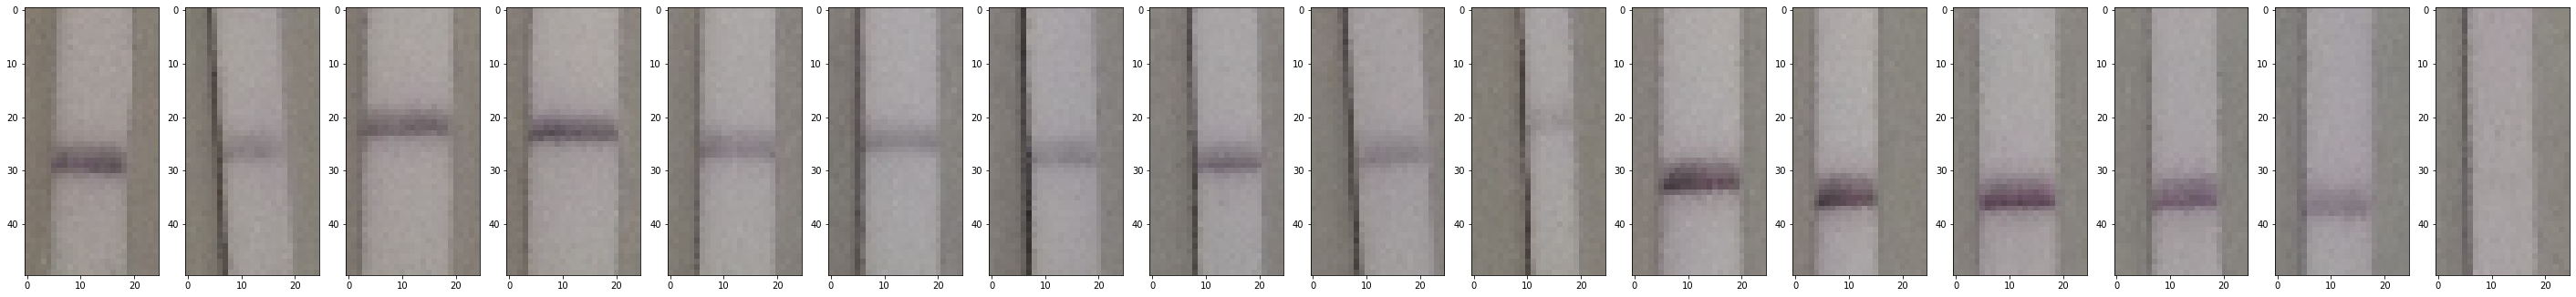

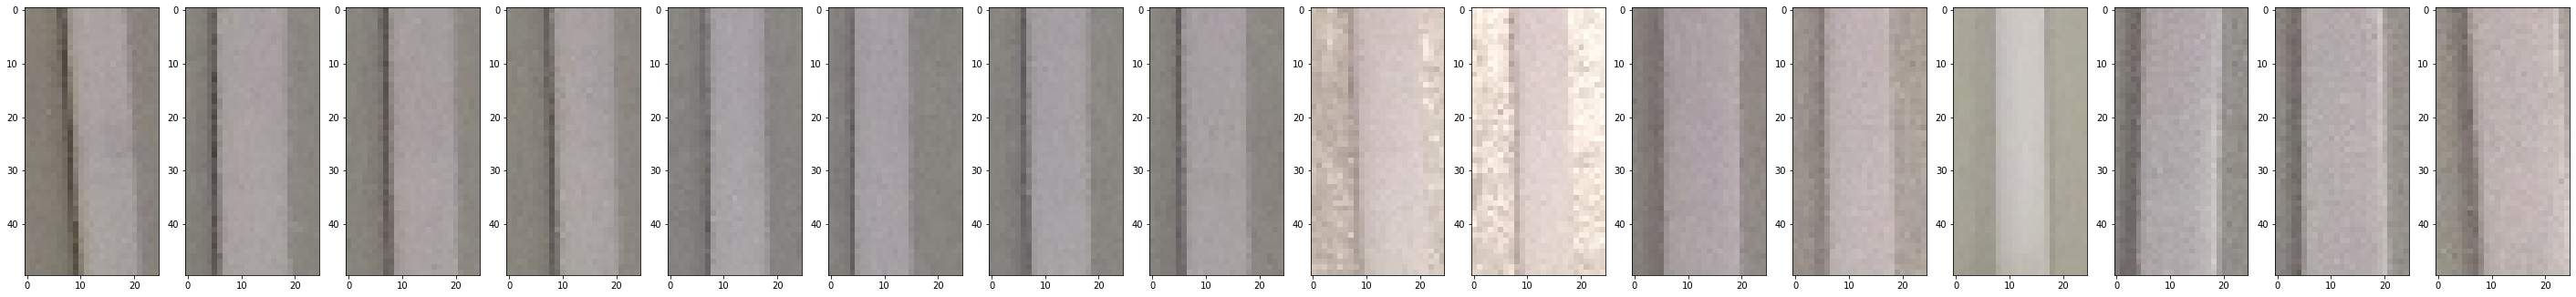

In [28]:
import skimage as sk
import numpy as np
from scipy import ndarray

target_image_shape = (100, 25, 4)
#target_image_shape = (25, 25, 4)

def load_images(paths):
    
    #images = ndarray(shape=(len(paths), *target_image_shape))
    images = ndarray(shape=(len(paths), 50, 25, 4))
    
    for ii, fname in enumerate(paths):
        image = sk.io.imread(fname)
        image = sk.transform.resize(image, target_image_shape, anti_aliasing=False)
        
        # Exclude the top half of the images
        image = image[50:, :, :]
        
        images[ii, :] = image
        
    return images

images_tp = load_images(images_tp_fn)
images_tn = load_images(images_tn_fn)

print('Number of tp', len(images_tp))
print('Number of tn', len(images_tn))

fig_tp = plt.figure(figsize=(50, 50))  # width, height in inches
fig_tn = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(4*4):
    sub = fig_tp.add_subplot(1,16, i + 1)
    sub.imshow(images_tp[i,:], interpolation='nearest')
    
    sub = fig_tn.add_subplot(1,16, i + 1)
    sub.imshow(images_tn[i,:], interpolation='nearest')
        

# Reserve some data for final validation

In [29]:
num_final_validation = 2

# Shuffle first
np.random.shuffle(images_tp)
np.random.shuffle(images_tn)

images_tp_valid = images_tp[:num_final_validation]
images_tn_valid = images_tn[:num_final_validation]

images_tp = images_tp[num_final_validation:]
images_tn = images_tn[num_final_validation:]

print('Number of tp', len(images_tp))
print('Number of tn', len(images_tn))

Number of tp 111
Number of tn 65


## Augment the images

In [41]:
import random

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array, var=0.001)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def no_transform(image_array: ndarray):
    return image_array


# the number of file to generate
num_files_desired = 1000

# dictionary of the transformations functions we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'none' : no_transform,
    'noise': random_noise #,
    #'horizontal_flip': horizontal_flip
}

def apply_transformations(images_to_transform):
    
    all_images = ndarray(shape=(num_files_desired,
                                images_to_transform.shape[-3],
                                images_to_transform.shape[-2],
                                images_to_transform.shape[-1]))
    
    for ii in range(num_files_desired):
        
        # Choose an image
        img_idx = np.random.randint(0, len(images_to_transform))
        our_img = images_to_transform[img_idx, :]
        
        # Apply a transformation
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](our_img)
        
        all_images[ii, :] = transformed_image
        
    return all_images
        
images_tp_aug = apply_transformations(images_tp)
images_tn_aug = apply_transformations(images_tn)

print('Augmented tp', len(images_tp_aug))
print('Augmented tn', len(images_tn_aug))

Augmented tp 1000
Augmented tn 1000


(50, 25, 4)


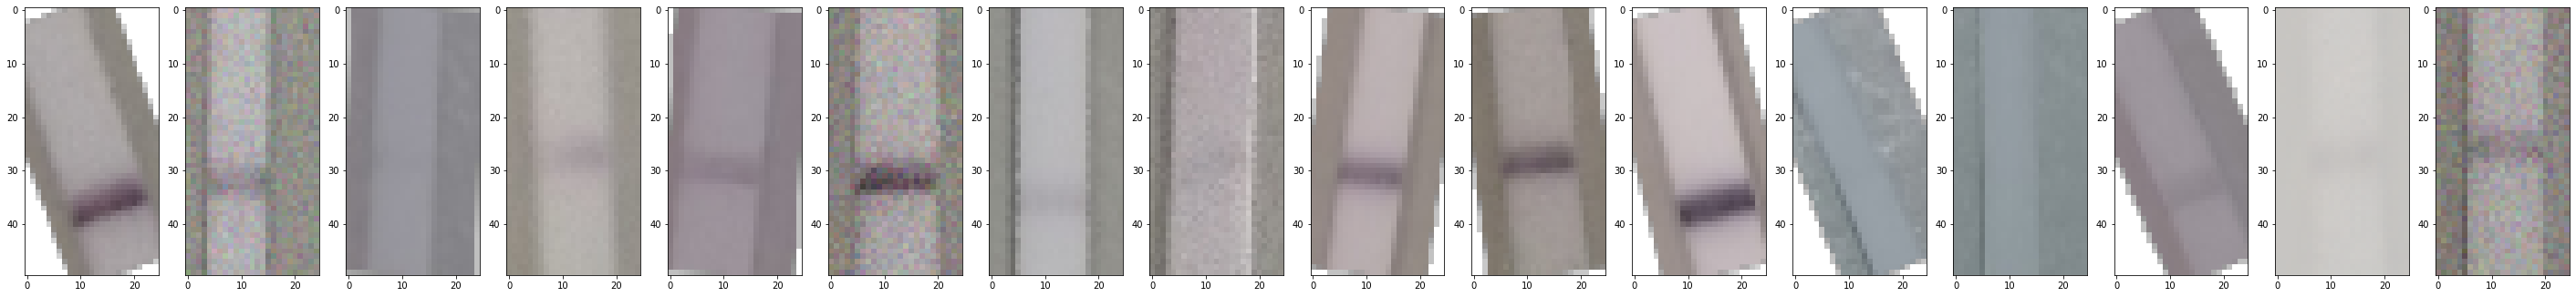

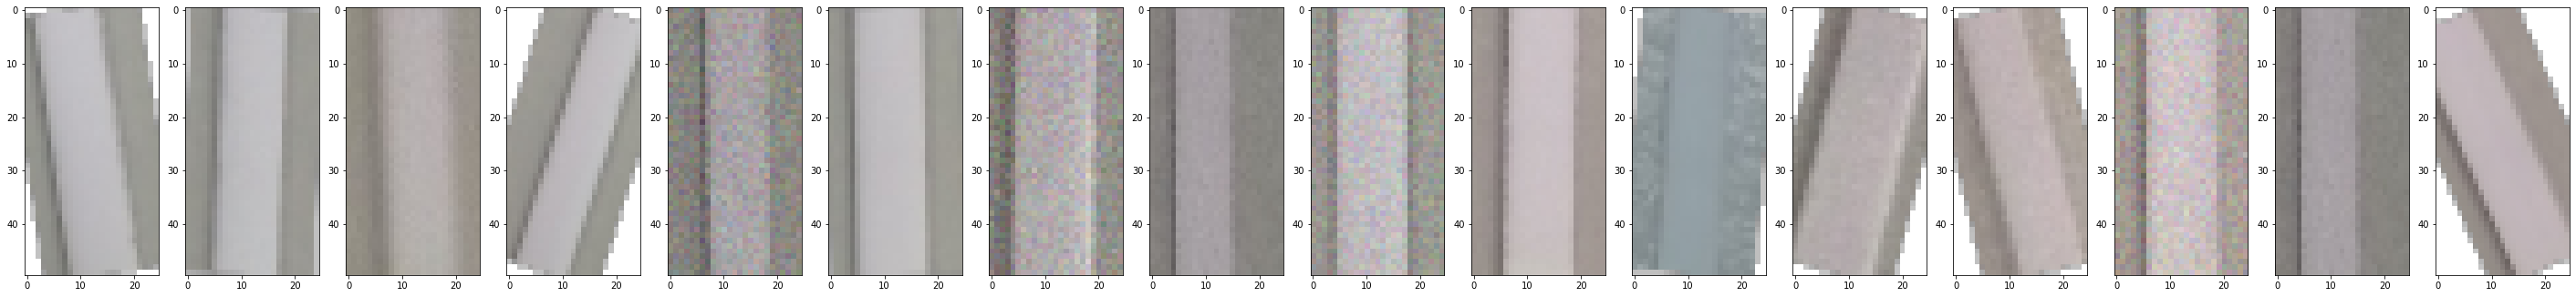

In [42]:
from matplotlib import pyplot as plt

fig_tp = plt.figure(figsize=(50, 50))  # width, height in inches
fig_tn = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(16):
    sub = fig_tp.add_subplot(1,16, i + 1)
    sub.imshow(images_tp_aug[i,:], interpolation='nearest')
    
    sub = fig_tn.add_subplot(1,16, i + 1)
    sub.imshow(images_tn_aug[i,:], interpolation='nearest')

print(images_tn_aug[1, :].shape)
#labels

In [47]:
# Shuffle the data and produce training and validation data

import numpy as np

# Split the data into training and validation

use_aug = False
if not use_aug:
    labels = np.concatenate([np.zeros((images_tp.shape[0], 1)), np.ones((images_tn.shape[0], 1))])
    images_all = np.concatenate([images_tp, images_tn])
else:
    labels = np.concatenate([np.zeros((images_tp_aug.shape[0], 1)), np.ones((images_tn_aug.shape[0], 1))])
    images_all = np.concatenate([images_tp_aug, images_tn_aug])

# Normalize pixel values to be between 0 and 1
images_all = images_all / 255.0

def unison_shuffled_copies(l, s):
    ax = 0
    assert l.shape[ax] == s.shape[ax]
    p = np.random.permutation(l.shape[ax])
    return l[p, :], s[p, :]

labels, images_all = unison_shuffled_copies(labels, images_all)

num_test = round(0.1*len(labels))
num_train = len(labels) - num_test

train_labels = labels[:num_train, :]
train_images = images_all[:num_train, :]

test_labels = labels[num_train:, :]
test_images = images_all[num_train:, :]


print('Number of training', len(train_images))
print('Number of testing', len(test_images))

Number of training 158
Number of testing 18


In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_images.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 23, 32)        1184      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 11, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 9, 64)         18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 4, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 2, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [49]:
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

accuracy = model.fit(train_images, train_labels, epochs=200,
              validation_data=(test_images, test_labels))

Train on 158 samples, validate on 18 samples
Epoch 1/200
158/158 [==============================] - 1s 4ms/sample - loss: 0.6857 - acc: 0.6519 - val_loss: 0.7189 - val_acc: 0.4444
Epoch 2/200
158/158 [==============================] - 0s 389us/sample - loss: 0.6588 - acc: 0.6519 - val_loss: 0.8189 - val_acc: 0.4444
Epoch 3/200
158/158 [==============================] - 0s 398us/sample - loss: 0.6491 - acc: 0.6519 - val_loss: 0.7692 - val_acc: 0.4444
Epoch 4/200
158/158 [==============================] - 0s 387us/sample - loss: 0.6488 - acc: 0.6519 - val_loss: 0.7505 - val_acc: 0.4444
Epoch 5/200
158/158 [==============================] - 0s 393us/sample - loss: 0.6488 - acc: 0.6519 - val_loss: 0.7560 - val_acc: 0.4444
Epoch 6/200
158/158 [==============================] - 0s 384us/sample - loss: 0.6504 - acc: 0.6519 - val_loss: 0.7846 - val_acc: 0.4444
Epoch 7/200
158/158 [==============================] - 0s 391us/sample - loss: 0.6474 - acc: 0.6519 - val_loss: 0.7748 - val_acc: 0.444

158/158 [==============================] - 0s 423us/sample - loss: 0.6021 - acc: 0.6519 - val_loss: 0.6516 - val_acc: 0.4444
Epoch 61/200
158/158 [==============================] - 0s 404us/sample - loss: 0.6076 - acc: 0.6519 - val_loss: 0.6278 - val_acc: 0.5556
Epoch 62/200
158/158 [==============================] - 0s 404us/sample - loss: 0.6003 - acc: 0.7215 - val_loss: 0.6697 - val_acc: 0.4444
Epoch 63/200
158/158 [==============================] - 0s 391us/sample - loss: 0.5496 - acc: 0.7152 - val_loss: 0.5942 - val_acc: 0.6667
Epoch 64/200
158/158 [==============================] - 0s 398us/sample - loss: 0.5269 - acc: 0.7215 - val_loss: 0.5823 - val_acc: 0.6667
Epoch 65/200
158/158 [==============================] - 0s 391us/sample - loss: 0.5015 - acc: 0.7911 - val_loss: 0.5061 - val_acc: 0.7778
Epoch 66/200
158/158 [==============================] - 0s 423us/sample - loss: 0.4916 - acc: 0.7785 - val_loss: 0.4681 - val_acc: 0.8333
Epoch 67/200
158/158 [=========================

158/158 [==============================] - 0s 410us/sample - loss: 0.2140 - acc: 0.9114 - val_loss: 0.1428 - val_acc: 0.9444
Epoch 120/200
158/158 [==============================] - 0s 410us/sample - loss: 0.1916 - acc: 0.8924 - val_loss: 0.1636 - val_acc: 0.9444
Epoch 121/200
158/158 [==============================] - 0s 403us/sample - loss: 0.2050 - acc: 0.9177 - val_loss: 0.1515 - val_acc: 0.9444
Epoch 122/200
158/158 [==============================] - 0s 410us/sample - loss: 0.2124 - acc: 0.9177 - val_loss: 0.1763 - val_acc: 0.9444
Epoch 123/200
158/158 [==============================] - 0s 410us/sample - loss: 0.1973 - acc: 0.9177 - val_loss: 0.1318 - val_acc: 0.8889
Epoch 124/200
158/158 [==============================] - 0s 404us/sample - loss: 0.2623 - acc: 0.8734 - val_loss: 0.1592 - val_acc: 0.9444
Epoch 125/200
158/158 [==============================] - 0s 411us/sample - loss: 0.1935 - acc: 0.9177 - val_loss: 0.2228 - val_acc: 0.9444
Epoch 126/200
158/158 [==================

158/158 [==============================] - 0s 423us/sample - loss: 0.1463 - acc: 0.9177 - val_loss: 0.1246 - val_acc: 0.9444
Epoch 179/200
158/158 [==============================] - 0s 423us/sample - loss: 0.1371 - acc: 0.9241 - val_loss: 0.1280 - val_acc: 0.9444
Epoch 180/200
158/158 [==============================] - 0s 417us/sample - loss: 0.1383 - acc: 0.9114 - val_loss: 0.1280 - val_acc: 0.9444
Epoch 181/200
158/158 [==============================] - 0s 379us/sample - loss: 0.1395 - acc: 0.9304 - val_loss: 0.1433 - val_acc: 0.9444
Epoch 182/200
158/158 [==============================] - 0s 404us/sample - loss: 0.1898 - acc: 0.8924 - val_loss: 0.1185 - val_acc: 0.8889
Epoch 183/200
158/158 [==============================] - 0s 398us/sample - loss: 0.1614 - acc: 0.9430 - val_loss: 0.1276 - val_acc: 0.9444
Epoch 184/200
158/158 [==============================] - 0s 423us/sample - loss: 0.1510 - acc: 0.9177 - val_loss: 0.1370 - val_acc: 0.9444
Epoch 185/200
158/158 [==================

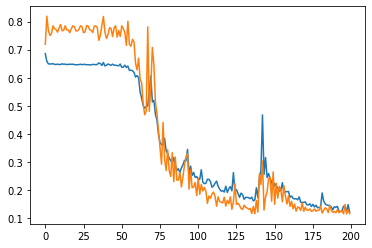

In [50]:
from matplotlib import pyplot as plt

plt.plot(accuracy.history['loss'])
plt.plot(accuracy.history['val_loss'])

In [ ]:
def check_image(test_image, scale=True):
    
    plt.imshow(test_image*255, extent=[0, 1, 0, 4])
    plt.show()
    print(model.predict(np.array([test_image])))
    
check_image(test_images[5, :])
check_image(test_images[7, :])

for ii in range(num_final_validation):
    check_image(images_tp_valid[ii, :]/255)
    check_image(images_tn_valid[ii, :]/255)